# Statistics on Decision Tree

We will arange data and train Desicion trees on the data.
The we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic Tree

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [2]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.INFO)
stocks = [TrainingData(sn).add_history(10).set_threshold(0.8).get() for sn in stock_names]

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018134653877025918
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.026397640541565882
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.018548151336335694
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0.036464497748678756
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.0321798749747933


In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [4]:
def run_model(model, stocks=stocks):
    scores = {sn: [] for sn in stock_names}
    validation_rounds = 3
    for i in range(validation_rounds):
        for sn, (data, classes) in zip(stock_names, stocks):
            scores[sn].append(sum(cross_val_score(model, data, classes))/3) 
    for sn in scores.keys():
        scores[sn] = sum(scores[sn])/validation_rounds
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

In [6]:
from sklearn.tree import DecisionTreeClassifier

# create iterables for all options and use itertools product
criterion=['gini', 'entropy']
max_depth=[5, 10, 100, None]
# using percentages
min_samples_leaf=[0.005, 0.01, 0.02, 0.05, 0.1]

tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), 7))), classes) for data, classes in stocks]

tmodels = [DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl) 
          for c, md, msl in product(criterion, max_depth, min_samples_leaf)]

In [7]:
def run_model_t(model):
    return run_model(model, tree_stocks)
taccuracies = list(map(run_model_t, tmodels))

In [8]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for tmodel, taccs in zip(tmodels, taccuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, tsn, tacc))
tresults = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))

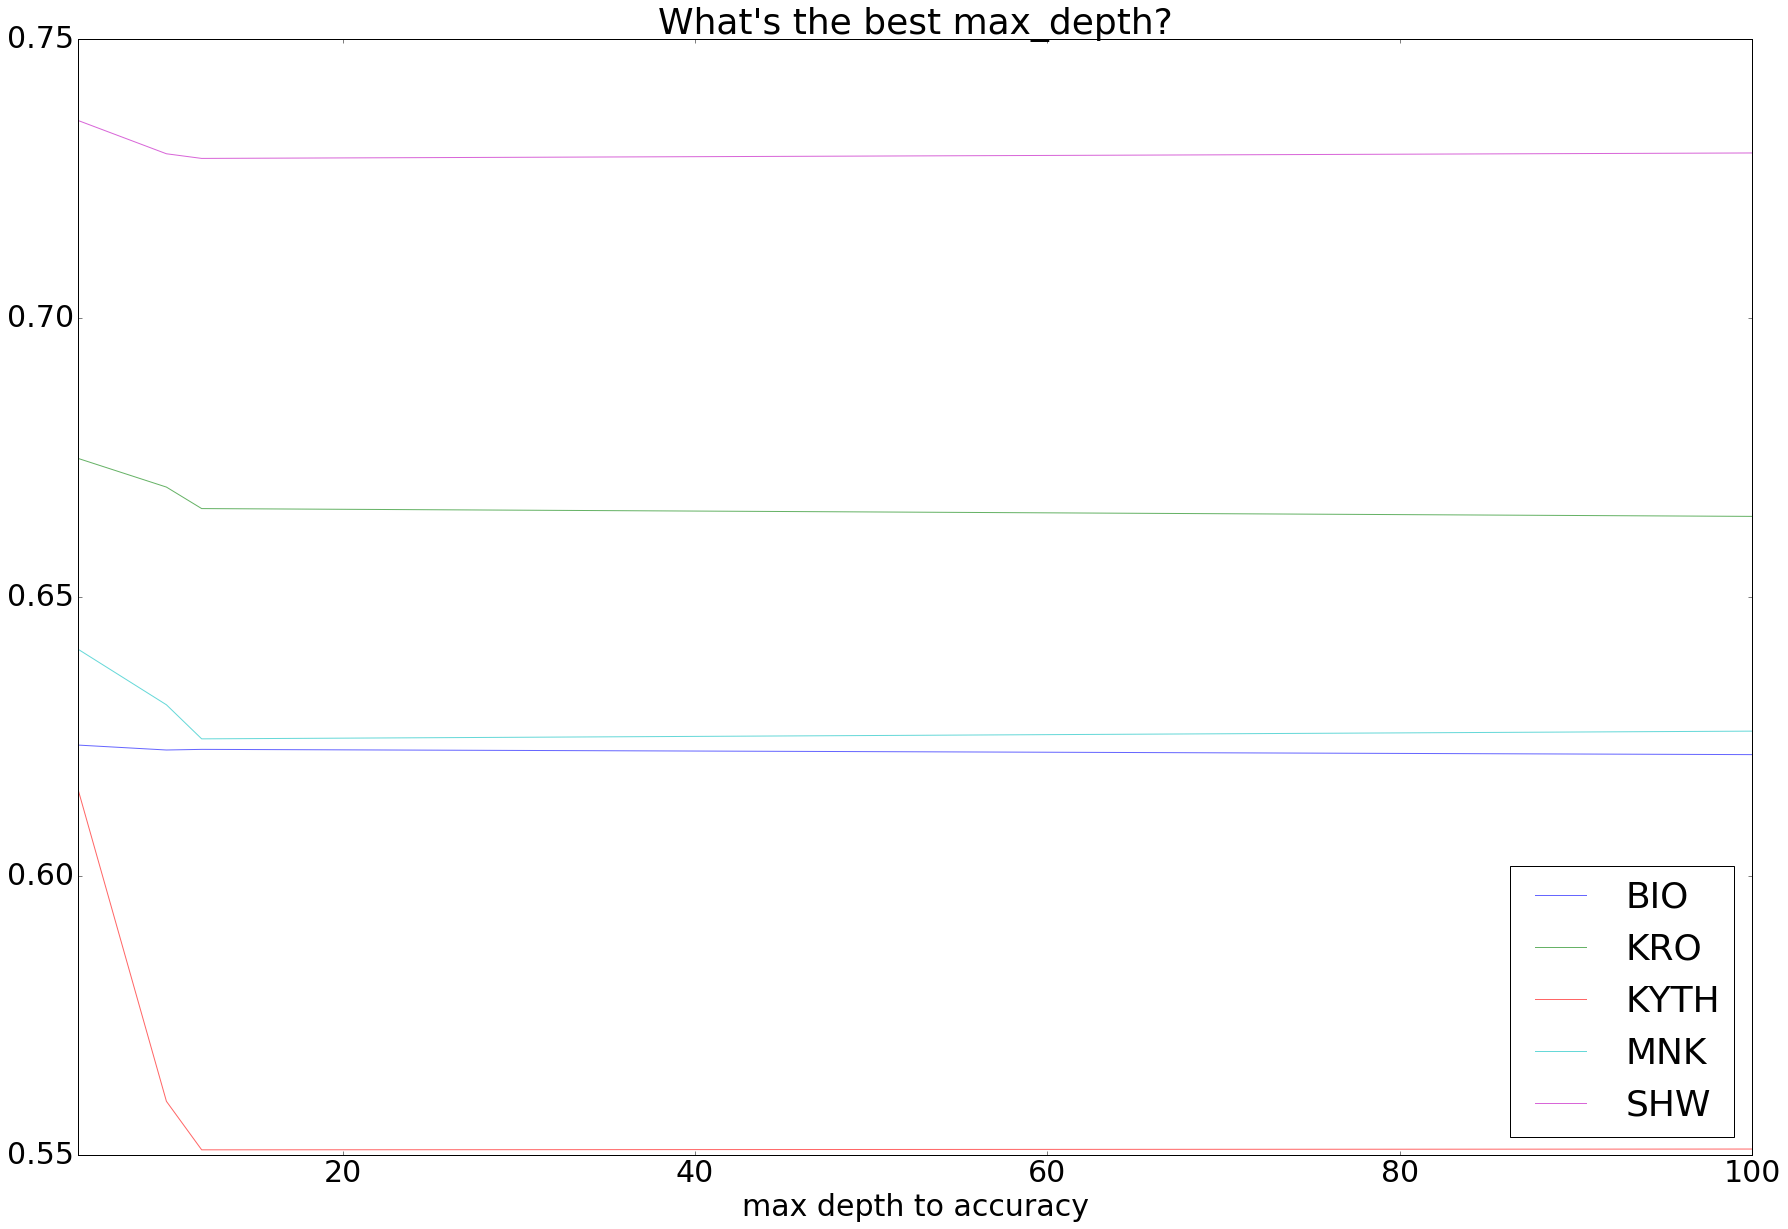

In [9]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('max_depth').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max depth to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

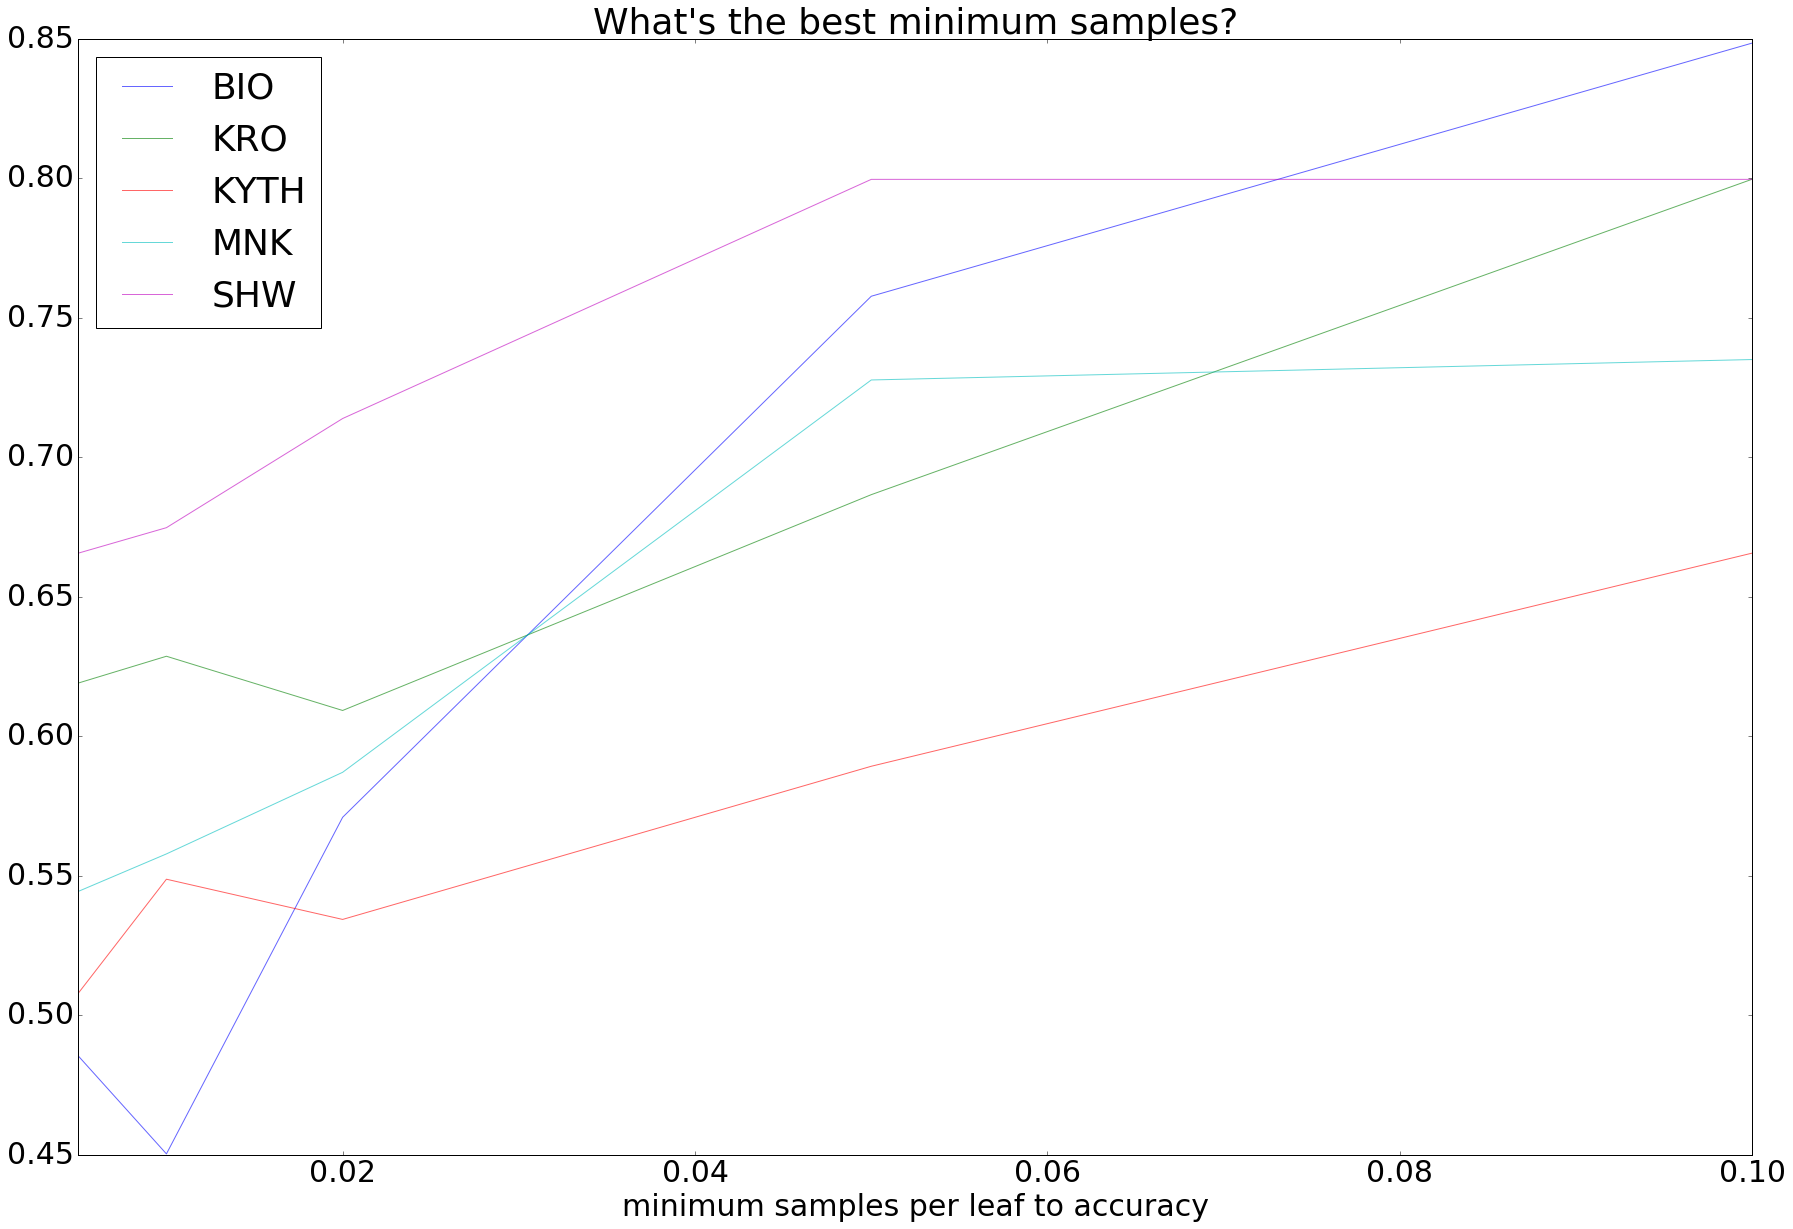

In [10]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('minimum samples per leaf to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best minimum samples?" )

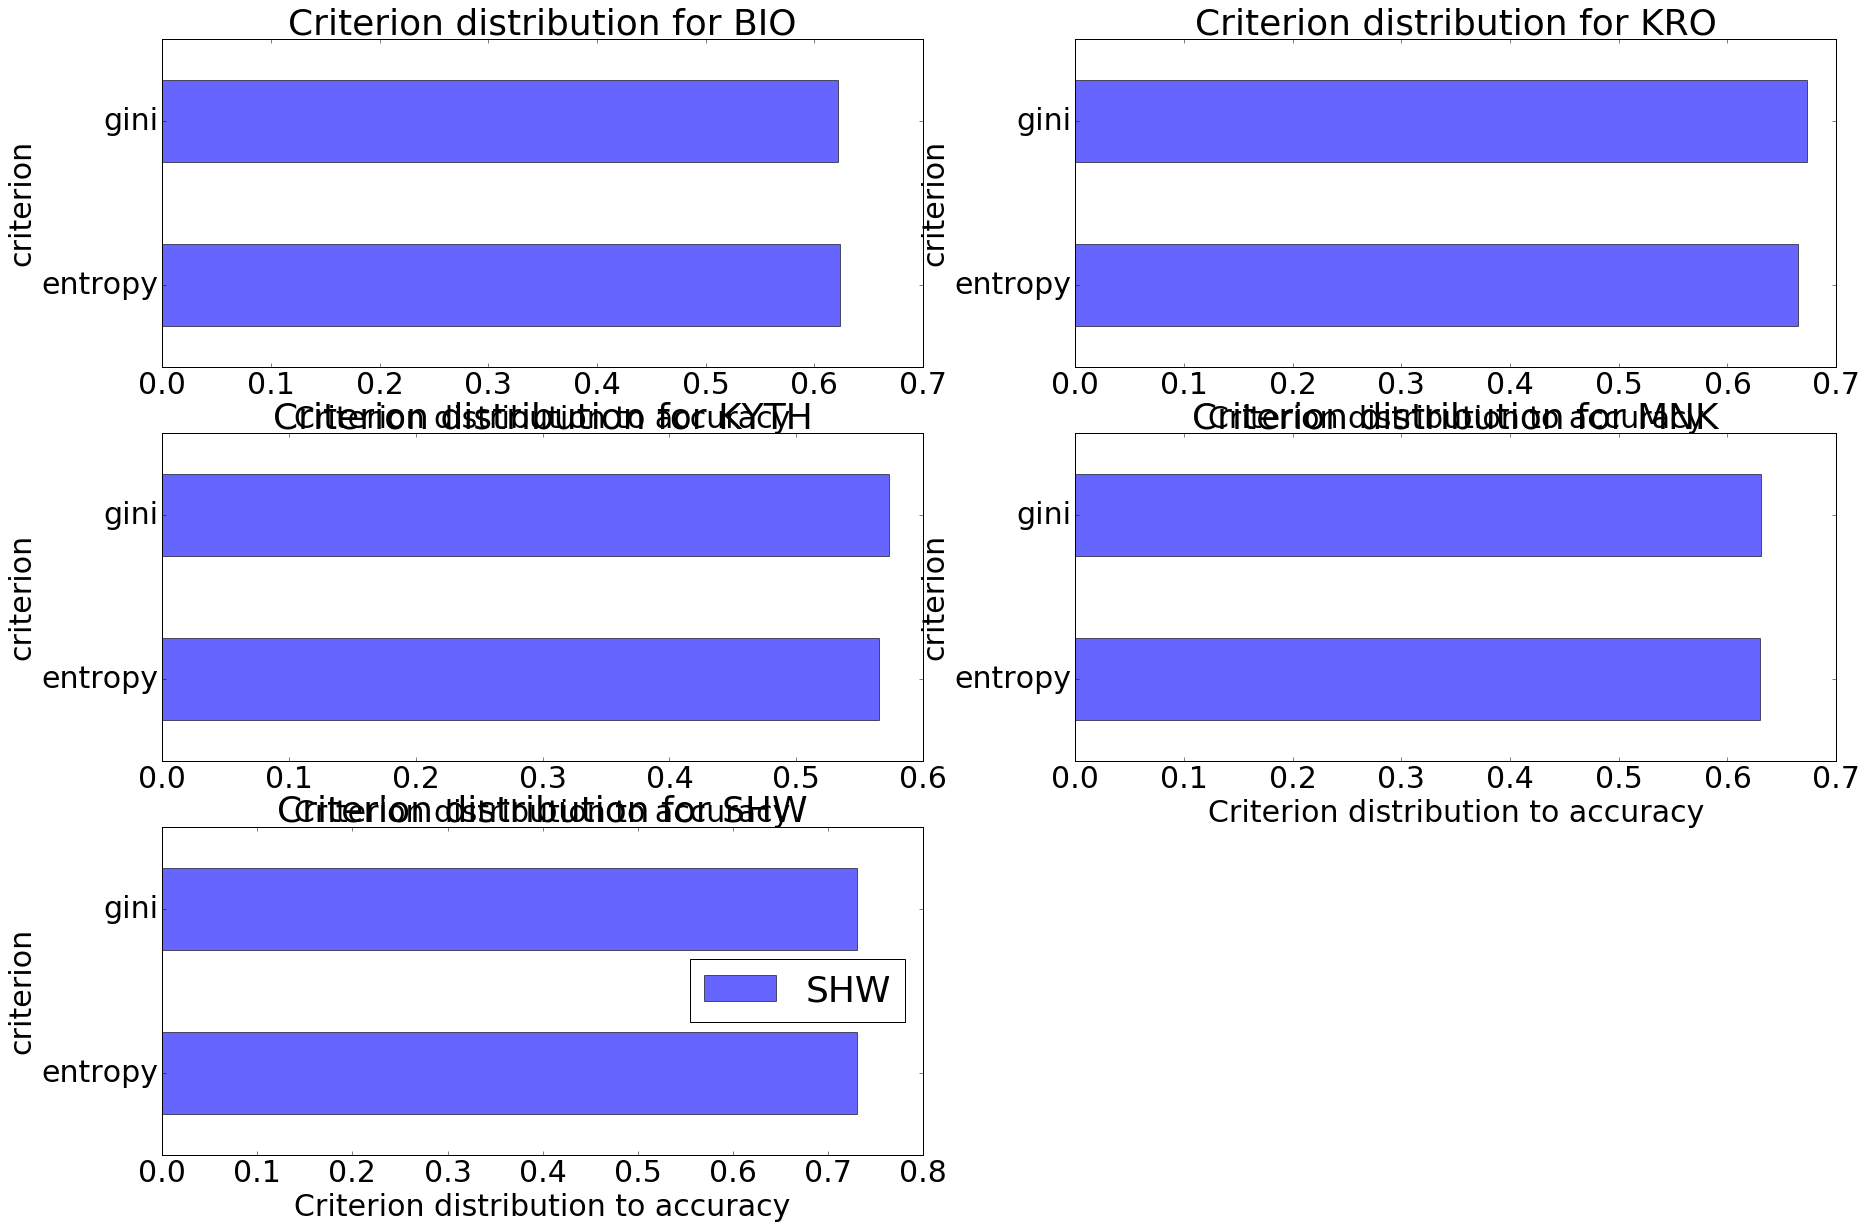

In [11]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(tresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution to accuracy')
    ax1.set_title("Criterion distribution for {}".format(name))
plt.legend(loc='best')


The best average accuracy model is:

In [12]:
print(get_best_model(tmodels, taccuracies))
print(get_best_median_model(tmodels, taccuracies))

(3.9808887141146827, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.79961811651516956, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


Which is less then just saying always false but we can work with it because we use adaboost later on. An important note is that we don't want to increase the amount of samples per leaf or decrease max depth as the classifier will be meaningless. Even we prefer to look at less samples per leaf so we will have more then 20 leaves:

In [17]:
t2combined = [(model, accs) for model, accs in zip(tmodels, taccuracies) if model.min_samples_leaf < 0.05]
t2models = [top[0] for top in t2combined]
t2accuracies = [top[1] for top in t2combined]

print(get_best_model(t2models, t2accuracies))
print(get_best_median_model(t2models, t2accuracies))

(3.059507170383128, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.59422059422059414, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.01,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


# Using the Quarter Classifier

The idea is that some quarters behave the same and so we can really decrease our data's variance if we cluster them together and then try to predict with the narowred down data.

In [16]:
from imp import reload
reload(Classifiers)

import Classifiers
from Classifiers.classifiers import Quarter

q_clusterer = Classifiers.create_quarter_clusterer(ld)

quarters = [list(Quarter.split_by_quarters(sn, data)) for sn, data in zip(stock_name, stocks)]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').